In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

In [24]:
train = datasets.MNIST( '../data', train = True, download = True, transform = transforms.Compose([transforms.ToTensor(), ]),)
test = datasets.MNIST( '../data', train = False, download = True, transform = transforms.Compose([transforms.ToTensor(), ]),)

In [25]:
x = train.data.float() / 255
y = train.targets

x = x.view(x.size(0),-1) #
print(x.size(0))
print(x.shape, y.shape)

60000
torch.Size([60000, 784]) torch.Size([60000])


In [26]:
input_size = x.size(-1)
output_size = int(max(y)) + 1 

print('input_size : %d, output_size : %d' % (input_size, output_size))

input_size : 784, output_size : 10


In [27]:
ratios = [.8,.2]

train_cnt = int(x.size(0)*ratios[0])
valid_cnt = int(x.size(0)*ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim = 0, index = indices)
y = torch.index_select(y, dim = 0, index = indices)

x = list(x.split(cnts, dim = 0))
y = list(y.split(cnts, dim = 0))

x += [(test.data.float() / 255).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x,y) :
    print(x_i.size(), y_i.size())
  
  

Train 48000 / Valid 12000 / Test 10000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [28]:
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, input_size, output_size, use_batch_norm=True, dropout_p=.4):
        super().__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.use_batch_norm = use_batch_norm
        self.dropout_p = dropout_p
        
        def get_regularizer(use_batch_norm, size):
            return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p)
        
        self.block = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.LeakyReLU(),
            get_regularizer(use_batch_norm, output_size),
        )

    def forward(self, x):
        y = self.block(x)
        return y

In [29]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, input_size, output_size, use_batch_norm=True, dropout_p=.4):
        super().__init__()

        self.layers = nn.Sequential(
            Block(input_size, 500, use_batch_norm, dropout_p),
            Block(500, 400, use_batch_norm, dropout_p),
            Block(400, 300, use_batch_norm, dropout_p),
            Block(300, 200, use_batch_norm, dropout_p),
            Block(200, 100, use_batch_norm, dropout_p),
            Block(100, 50, use_batch_norm, dropout_p),
            nn.Linear(50, output_size),
            nn.LogSoftmax(dim=-1),
        )

    def forward(self, x):
        y = self.layers(x)
        return y


In [30]:
model = MyModel(input_size, output_size, use_batch_norm = True)

print(model)

MyModel(
  (layers): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=500, out_features=400, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=400, out_features=300, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Block(
      (block): Sequential(
        (0): Linear(in_features=300, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(200, e

In [31]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss()

In [32]:
n_epochs = 1000
batch_size = 256
print_interval = 10

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [59]:
train_history, valid_history = [], []

for i in range(n_epochs):
    model.train()
    indices = torch.randperm(x[0].size(0))
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_):
        
        y_hat_i = model(x_i)
        
        loss = crit(y_hat_i, y_i.squeeze())
        
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += float(loss)

    train_loss = train_loss / len(x_)
    model.eval()
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())
            valid_loss += float(loss)
            y_hat += [y_hat_i]

        valid_loss = valid_loss / len(x_)

        train_history += [train_loss]
        valid_history += [valid_loss]  # for plotting the graph

        if (i + 1) % print_interval == 0:
            print('Epoch %d : train loss = %4e valid_loss = %.4e lowest_loss = %.4e' % (i + 1, train_loss, valid_loss, lowest_loss,))

        if valid_loss <= lowest_loss:
            lowest_loss = valid_loss
            lowest_epoch = i
            best_model = deepcopy(model.state_dict())
        else:
            if early_stop > 0 and lowest_epoch + early_stop < i + 1:
                print('There is no improvement during last %d epochs' % early_stop)
                break

print("the best validation loss from epochs %d : %.4e" % (lowest_epoch + 1, lowest_loss))

model.load_state_dict(best_model)


Epoch 10 : train loss = 2.096704e-02 valid_loss = 9.1012e-02 lowest_loss = 7.8750e-02
Epoch 20 : train loss = 1.508402e-02 valid_loss = 8.6871e-02 lowest_loss = 7.3429e-02
Epoch 30 : train loss = 7.846153e-03 valid_loss = 8.1275e-02 lowest_loss = 7.3429e-02
Epoch 40 : train loss = 4.098275e-03 valid_loss = 9.2633e-02 lowest_loss = 7.3429e-02
Epoch 50 : train loss = 6.502212e-03 valid_loss = 1.0260e-01 lowest_loss = 7.3429e-02
Epoch 60 : train loss = 5.979736e-03 valid_loss = 9.6648e-02 lowest_loss = 7.3429e-02
There is no improvement during last 50 epochs
the best validation loss from epochs 16 : 7.3429e-02


<All keys matched successfully>

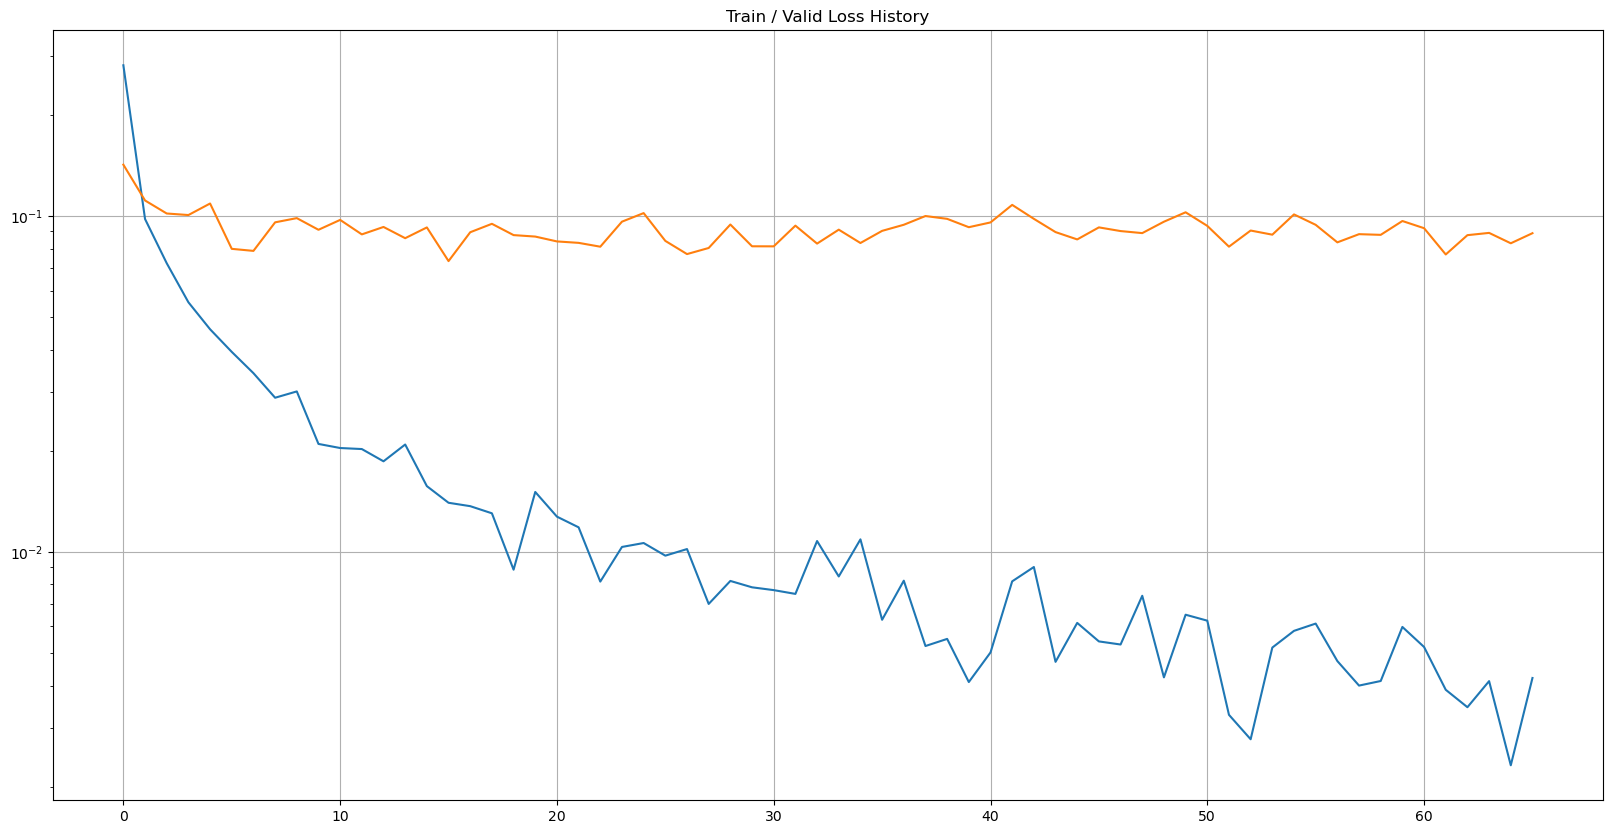

In [60]:
plot_from = 0
plt.figure(figsize = (20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot( range(plot_from, len(train_history)), train_history[plot_from:], range(plot_from, len(valid_history)), valid_history[plot_from:],)

plt.yscale("log")
plt.show()

In [62]:
test_loss = 0
y_hat = []

model.eval()
with torch.no_grad() :
    x_ = x[-1].split(batch_size, dim =0)
    y_ = y[-1].split(batch_size, dim =0)
    
    for x_i, y_i in zip(x_,y_) :
        y_hat_i =model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())
        
        test_loss += loss
        
        y_hat += [y_hat_i]
        
test_loss = test_loss / len(x)
y_hat = torch.cat(y_hat , dim =0)

print("test loss : %.4e" % test_loss)

correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim = -1)).sum()
total_cnt = float(y[-1].size(0))

print("Test Accuracy : %.4f" % (correct_cnt/total_cnt))

test loss : 9.8447e-01
Test Accuracy : 0.9820
